# Pairs Trading Strategy Analysis using Stocks

**IDEA**

Pair trading is a market-neutral trading strategy that matches a long position with a short position in a pair of highly correlated instruments such as two stocks, exchange-traded funds (ETFs), currencies, commodities or options.

**STRATEGY**

1. Retrieve Data: We will use Yahoo Finance as a provider for our data.
2. Data Processing: Clean the data if needed and interpolate potential missing data.
3. Identification of Pairs: The first step of building the strategy is to identify two closely related securities, often two stocks operating within the same sector. These stocks should have a high historical correlation. In order to do that we will perform a cointegration test. Based on the results on our universe, we will select the pair that have potential.
4. Implement the Strategy: The strategy is based on the assumption that the price difference between the paired securities tends to revert to its historical average. When the prices of paired stocks move away from each other (diverge), this strategy assumes that they will eventually converge back to their mean.
5. Trading: When pairs from the trade eventually deviate, a trader would seek to take a dollar-matched long position in the under performing security and sell short the outperforming security. If the securities return to their historical correlation, a profit is made from the convergence of the prices.

**STEP 0: Import Libraries**

In [1]:
# Retrieve and Manipulate Data
import yfinance as yf
import pandas as pd
import numpy as np
import random

# Plot Results
import seaborn as sns
import matplotlib.pyplot as plt

# Perform Cointegration and Pairing
from statsmodels.tsa.stattools import coint
from itertools import combinations

# Perform Strategy Analysis
from analysis import calculate_profit, plot_strategy

**STEP 1: Retrieve Data**

In this part, we will use a subset of the S&P 500 as our universe. We will retrieve the Adjusted Close Price between '2021-01-01' and '2023-01-01'.

In [2]:
tickers = ['SYF', 'UAL', 'WRB', 'EMN', 'KDP', 'HWM', 'CTRA', 'MTCH', 'O', 'CRM', 'TDG', 'GLW', 'CINF', 'PHM', 'CMCSA', 'CTVA', 'WM', 'ORLY', 'BLDR', 'AJG', 'KEYS', 'APD', 'AEP', 'T', 'APTV', 'RCL', 'AXP', 'RL', 'RJF', 'FLT', 'SYK', 'FCX', 'BEN', 'DOV', 'LYV', 'L', 'MA', 'MO', 'TMUS', 'MOS', 'DD', 'PFE', 'ADI', 'AMP', 'MMC', 'JPM', 'TYL', 'REGN', 'ORCL', 'WAB']

In [3]:
data = yf.download(tickers, start='2021-01-01', end='2023-01-01')['Adj Close']

[*********************100%%**********************]  50 of 50 completed


In [4]:
data.head()

,ADI,AEP,AJG,AMP,APD,APTV,AXP,BEN,BLDR,CINF,...,SYF,SYK,T,TDG,TMUS,TYL,UAL,WAB,WM,WRB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,138.322693,72.294289,115.750801,178.263992,249.729462,129.509995,113.141541,21.429893,39.830002,78.375313,...,31.479931,231.214828,17.343357,551.150940,131.331177,431.609985,41.630001,71.216286,109.263992,40.427818
2021-01-05,140.795181,72.196777,114.980667,177.221542,262.942230,133.389999,113.745399,21.377071,39.700001,77.633293,...,32.060844,231.833939,17.237314,561.983154,130.755997,432.239990,43.400002,72.108330,109.625565,40.079185
2021-01-06,141.429840,72.773064,117.377701,187.389938,270.000183,138.110001,117.953209,22.477621,40.939999,81.287720,...,34.006435,234.532822,17.573105,561.683105,130.438644,433.730011,43.540001,77.588005,112.051964,41.455009
2021-01-07,147.407196,70.831367,117.762764,189.654846,265.642517,144.800003,117.020195,22.442404,42.389999,81.324821,...,33.849682,235.761337,17.620235,567.572815,132.084869,437.670013,43.619999,80.322960,112.327911,41.093933
2021-01-08,148.477631,70.201897,116.338013,191.000519,266.061554,145.559998,117.135620,22.257509,40.169998,81.417557,...,33.729813,235.703293,17.498720,575.150696,133.939362,436.390015,43.290001,79.626968,112.851257,41.311825


**STEP 2: Data Processing**

Since we are using a large universe, we will not introduce any potential misleading interpolation in our data as we will be using cointegration in the following steps. However, there are several way to compute missing data. 



In [5]:
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
tickers = data.columns.tolist()

In [6]:
adj_close_data = np.column_stack([data[ticker].values for ticker in tickers])

**STEP 3: Identification of Pairs**

Quantitative analysts, or quants, identify potential trading opportunities by examining the cointegration relationship between assets. They issue buy and sell orders when the spread between these assets deviates from its historical average, with the expectation that the spread will eventually return to its long-term equilibrium.

The following code will explore the selected set of stocks, to uncover any concealed relationships.

The code tests a statistical concept known as the Null Hypothesis ($H_0$), which assumes the absence of any effect or relationship. Generally, if the p-value falls below $0.02$, the $H_0$ is rejected, indicating a significant relationship between the pair.

In [7]:
p_value_threshold = 0.02

n = len(tickers)
pvalue_matrix = np.ones((n, n))
for i, j in combinations(range(n), 2):
    result = coint(adj_close_data[:, i], adj_close_data[:, j])
    pvalue_matrix[i, j] = result[1]

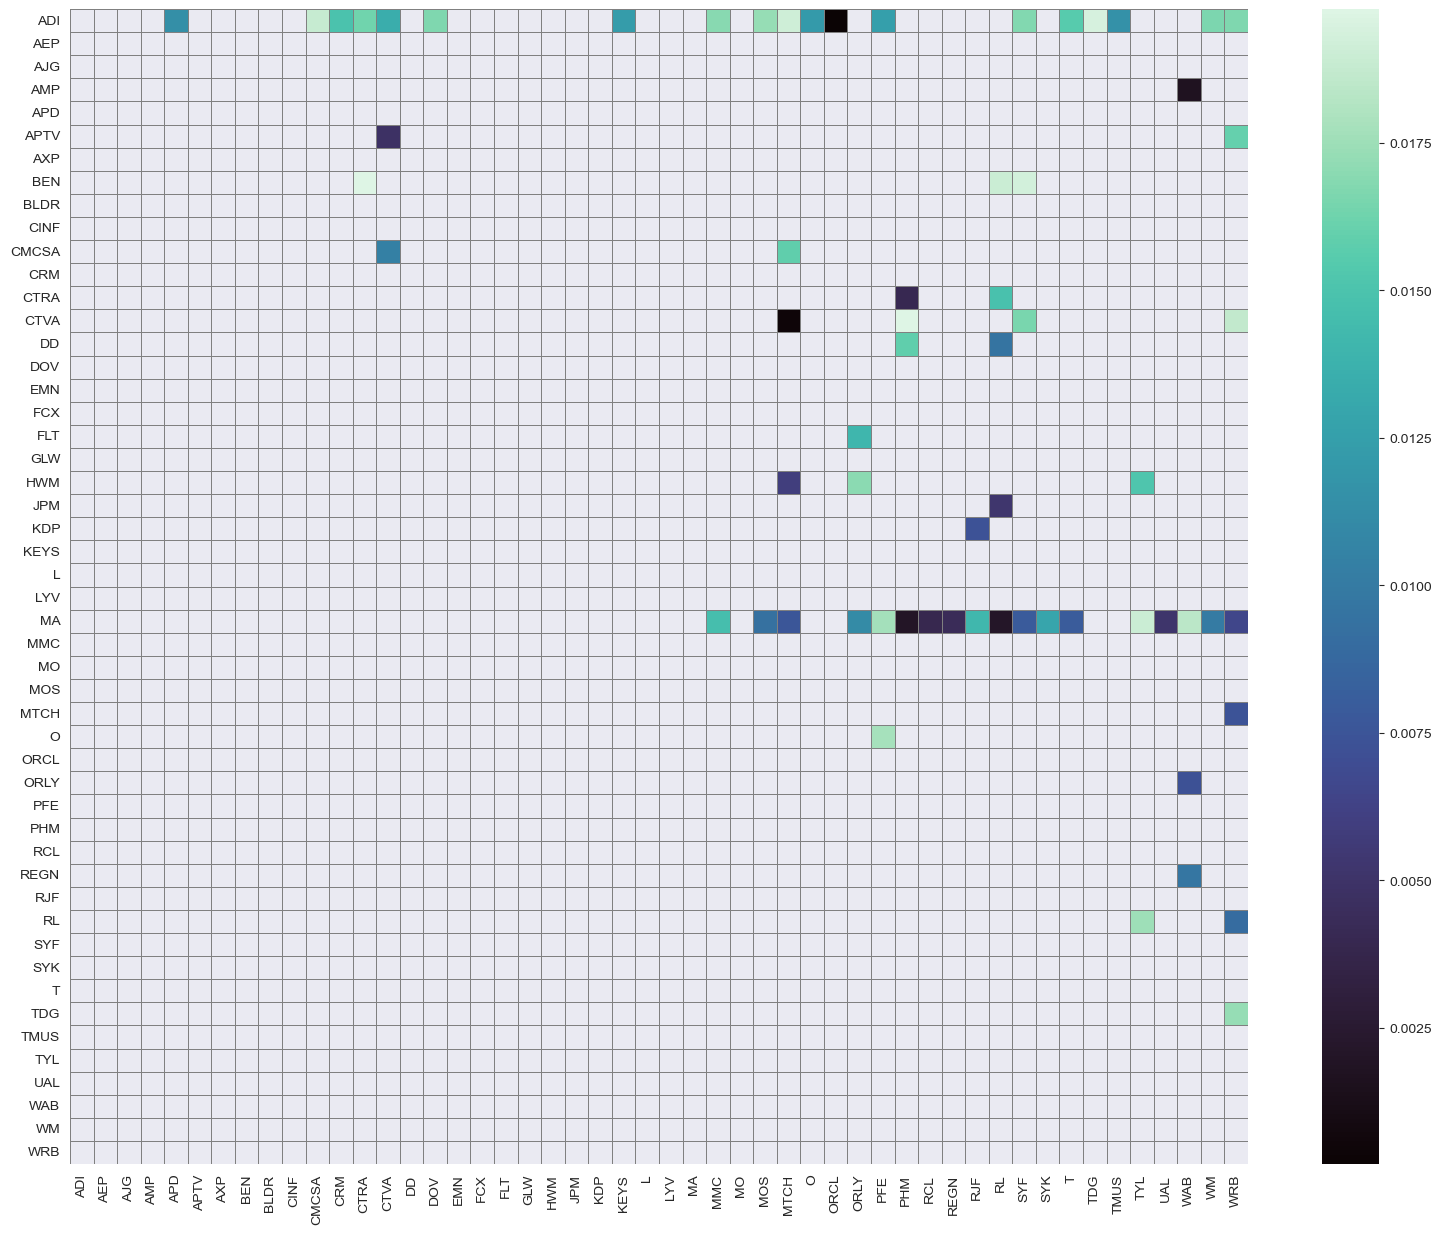

In [8]:
plt.figure(figsize=(19, 15))
heatmap = sns.heatmap(pvalue_matrix, xticklabels=tickers,
                      yticklabels=tickers, cmap='mako',
                      mask=(pvalue_matrix > p_value_threshold),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=10)
plt.show()

As stated above, the smaller the p-value is, the greater is the  long-term relation between the two stocks. We can see from this map the pairs that have a p-value inferior to the threshold. Let's find the pair that have a smallest p-value and perform the strategy on it. 

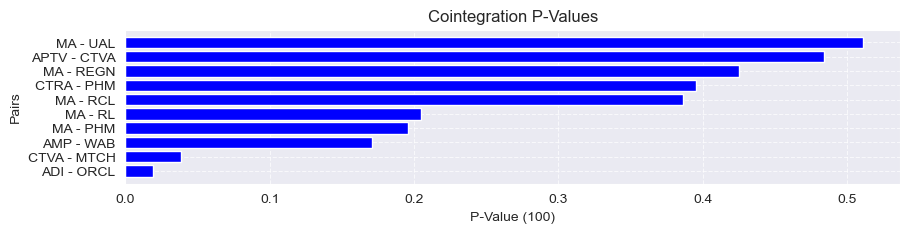

In [9]:
# Retrieve the pairs that respect the p_value_threshold 
pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j]) for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

sorted_pairs = sorted(pairs, key= lambda x: x[2])
sorted_pairs= sorted_pairs[:10]
sorted_pairs_labels, pairs_p_values = zip(*[(f'{y1} - {y2}', p*100) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(10, 2))
plt.barh(sorted_pairs_labels, pairs_p_values, color='blue')
plt.xlabel('P-Value (100)')
plt.ylabel('Pairs')
plt.title('Cointegration P-Values')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

**STEP 4: Implement the Strategy**

In order to implement our strategy we will select the pair that have the smallest p-value. In this case, we will use 'ADI' and 'ORCL'. We saw that from '2021-01-01' to '2023-01-01', the two were highly cointegrated, let's how the strategy would perform during that period of time as a reference and evaluate how it would perform in the future using the data available from '2023-01-01' to today.

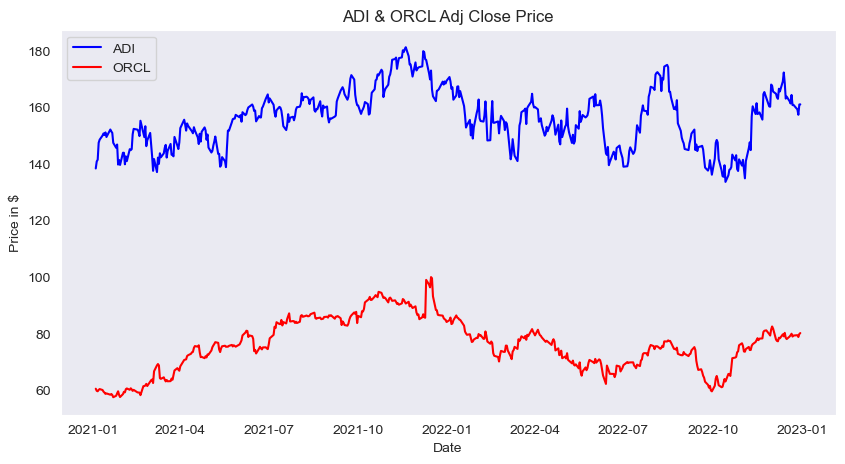

In [10]:
plt.figure(figsize=(10,5))

plt.plot(data['ADI'], label='ADI', color='blue')
plt.plot(data['ORCL'], label='ORCL', color='red')
plt.title('ADI & ORCL Adj Close Price')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

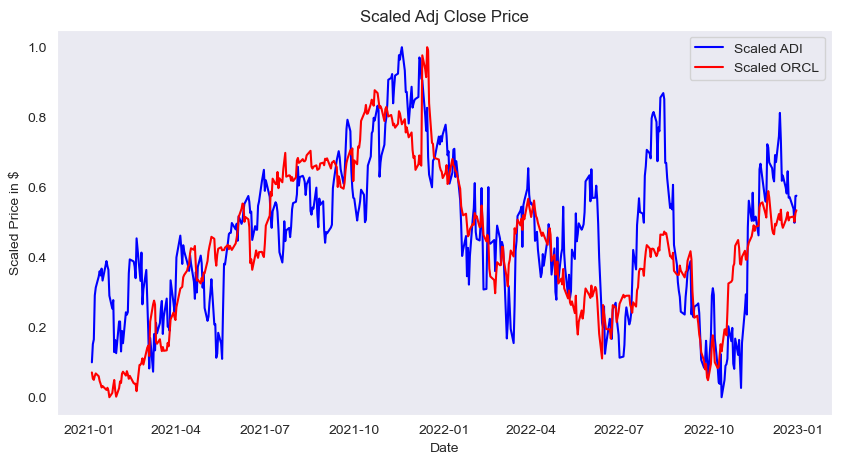

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data_ADI = scaler.fit_transform(data['ADI'].values.reshape(-1,1))
scaled_data_MOS = scaler.fit_transform(data['ORCL'].values.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.plot(data.index, scaled_data_ADI, label='Scaled ADI', color='blue')
plt.plot(data.index, scaled_data_MOS, label='Scaled ORCL', color='red')
plt.ylabel('Scaled Price in $')
plt.xlabel('Date')
plt.title('Scaled Adj Close Price')
plt.legend()
plt.grid()
plt.show()

We will create trading signals using the Z-score and mean. With a rolling window, so we don't have to split into training and tests sets. The Z-score is denoted as:
 $$ Z = \frac{X - \mu}{\sigma}$$ 

- $X$ is the price we want to standardize.
- $\mu$ is the mean of the rolling window.
- $\sigma$ is the standard deviation of the rolling window.

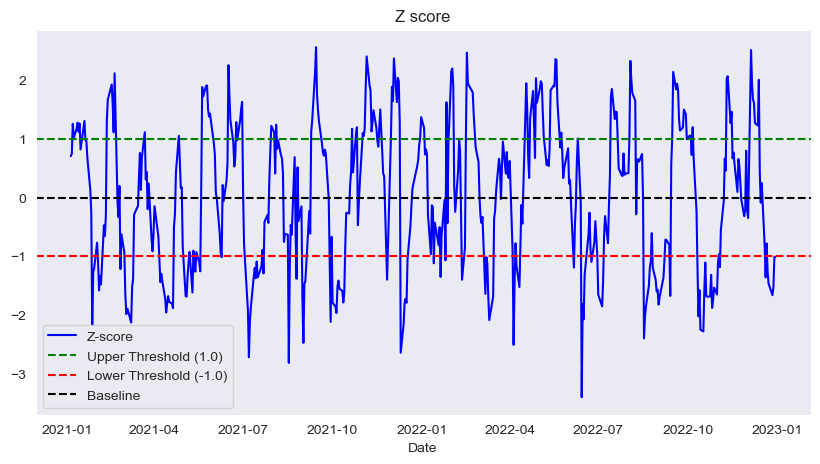

In [12]:
ratios = data['ADI']/data['ORCL']
mean_ratios = ratios.rolling(window=15, min_periods=1, center=False).mean()
std_ratios = ratios.rolling(window=15, min_periods=1, center=False).std()

zscore = (ratios - mean_ratios)/std_ratios

plt.figure(figsize=(10,5))
plt.plot(zscore, label='Z-score', color='blue')
plt.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
plt.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
plt.axhline(0, color="black", linestyle='--', label="Baseline")
plt.title('Z score')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

**Generate buy and sell signals**

When the Z-score surpasses a predefined threshold, it generates a trading signal. If the Z-score goes above +1, it indicates that one asset is overvalued compared to the other, signaling a sell for the overvalued asset and a buy for the undervalued one.

In our case %%%
Long the spread: place a short position in JPM (winner stock) and a long position in BAC (loser stock) when the z-score crosses 1.2 from below, and there is no position.

Short the spread: place a long position in JPM (loser stock) and a short position in BAC (winner stock) when the z-score crosses 1.2 from above and there is no position.%%%

In [13]:
def generate_signals(data_df, tickers, up_threshold = 1, down_threshold = -1):
    
    [ticker1, ticker2] = tickers
    
    ratios = data_df[ticker1]/data_df[ticker2]
    mean_ratios = ratios.rolling(window=15, min_periods=1, center=False).mean()
    std_ratios = ratios.rolling(window=15, min_periods=1, center=False).std()
    
    zscore = (ratios - mean_ratios)/std_ratios
    
    buy1 = ratios.copy()
    sell1 = ratios.copy()
    buy2 = ratios.copy()
    sell2 =ratios.copy()
    
    # Signal for the 1st ticker
    buy1[zscore > down_threshold] = 0
    sell1[zscore < up_threshold] = 0
    
    # Signal for the 2nd ticker
    buy2[zscore < down_threshold] = 0
    sell2[zscore > up_threshold] = 0
    
    signals1 = pd.DataFrame(index=ratios.index)
    signals1['signal'] = np.where(buy1 > 0, 1, np.where(sell1 < 0, -1, 0))
    signals1['orders'] = signals1['signal'].diff()
    signals1.loc[signals1['orders'] == 0, 'orders'] = None
    
    signals2 = pd.DataFrame(index=ratios.index)
    signals2['signal'] = np.where(buy2 > 0, 1, np.where(sell2 < 0, -1, 0))
    signals2['orders'] = signals2['signal'].diff()
    signals2.loc[signals2['orders'] == 0, 'orders'] = None
    
    return signals1, signals2

In [14]:
# Retrieve the signals
tickers_= ['ADI','ORCL']
signals_ADI, signals_ORCL = generate_signals(data, tickers_)

<Figure size 2600x1800 with 0 Axes>

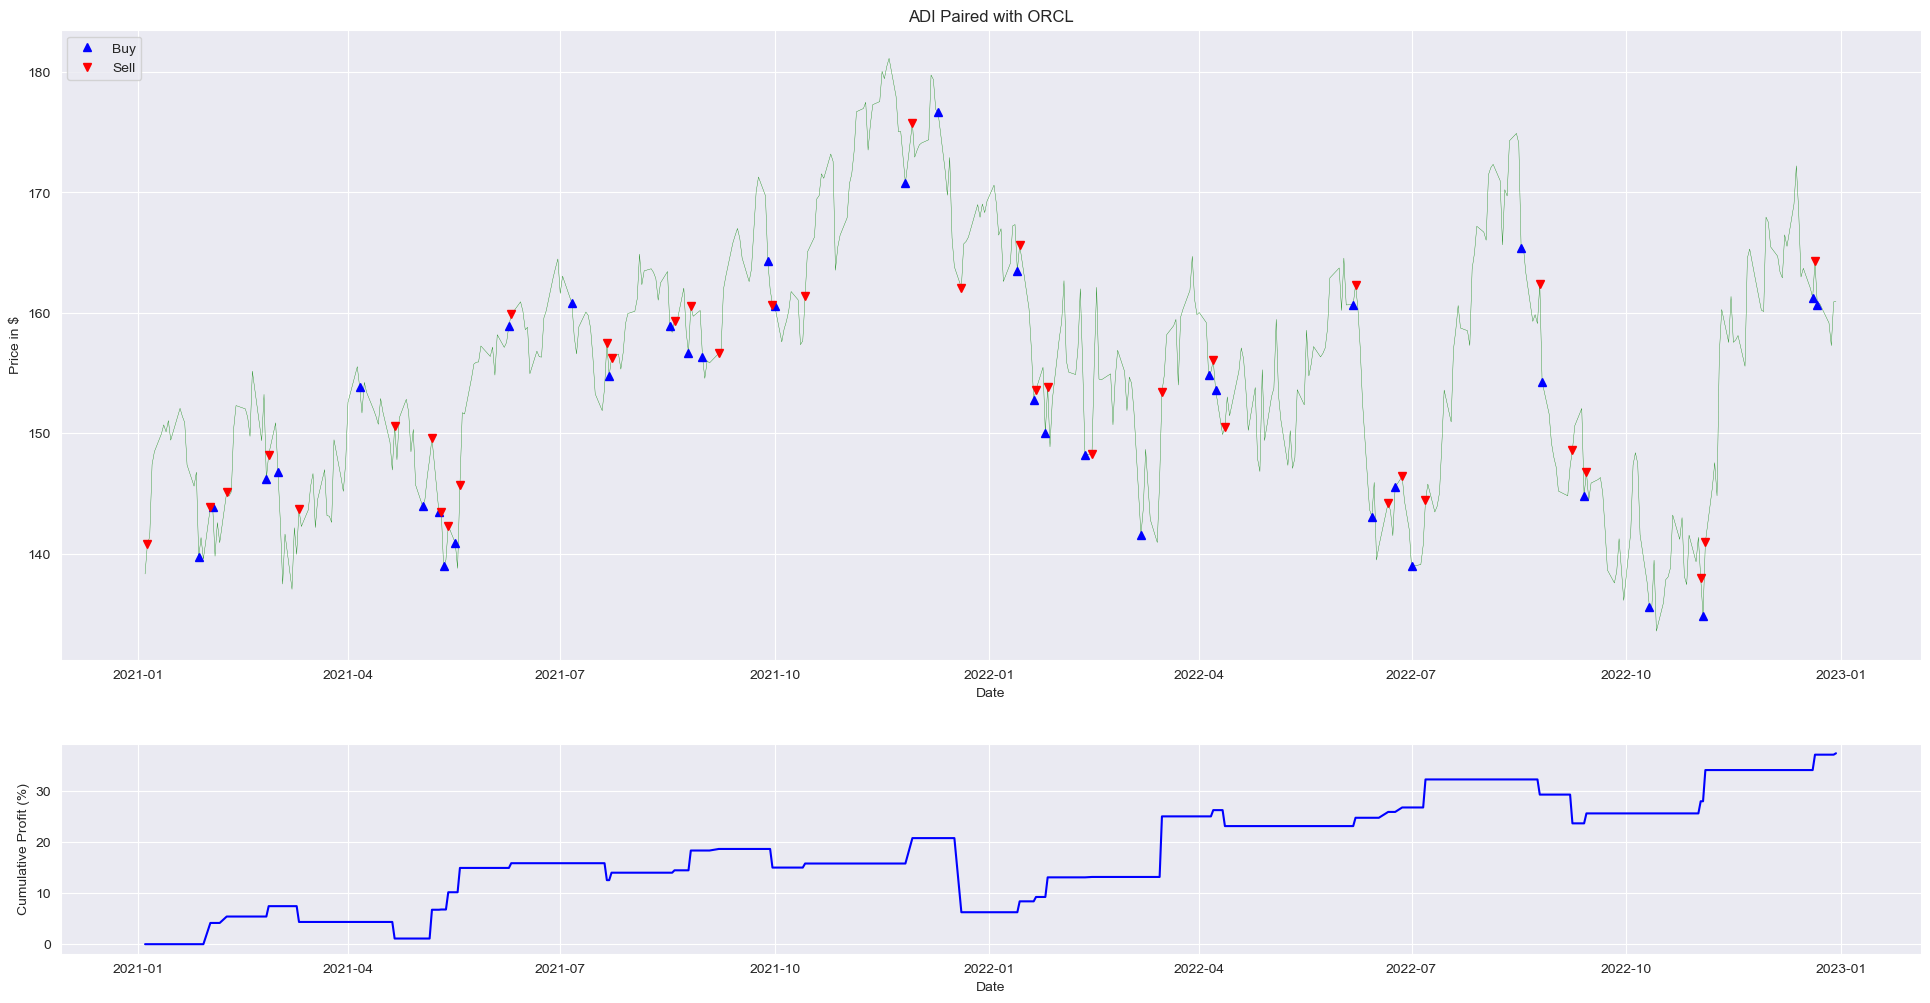

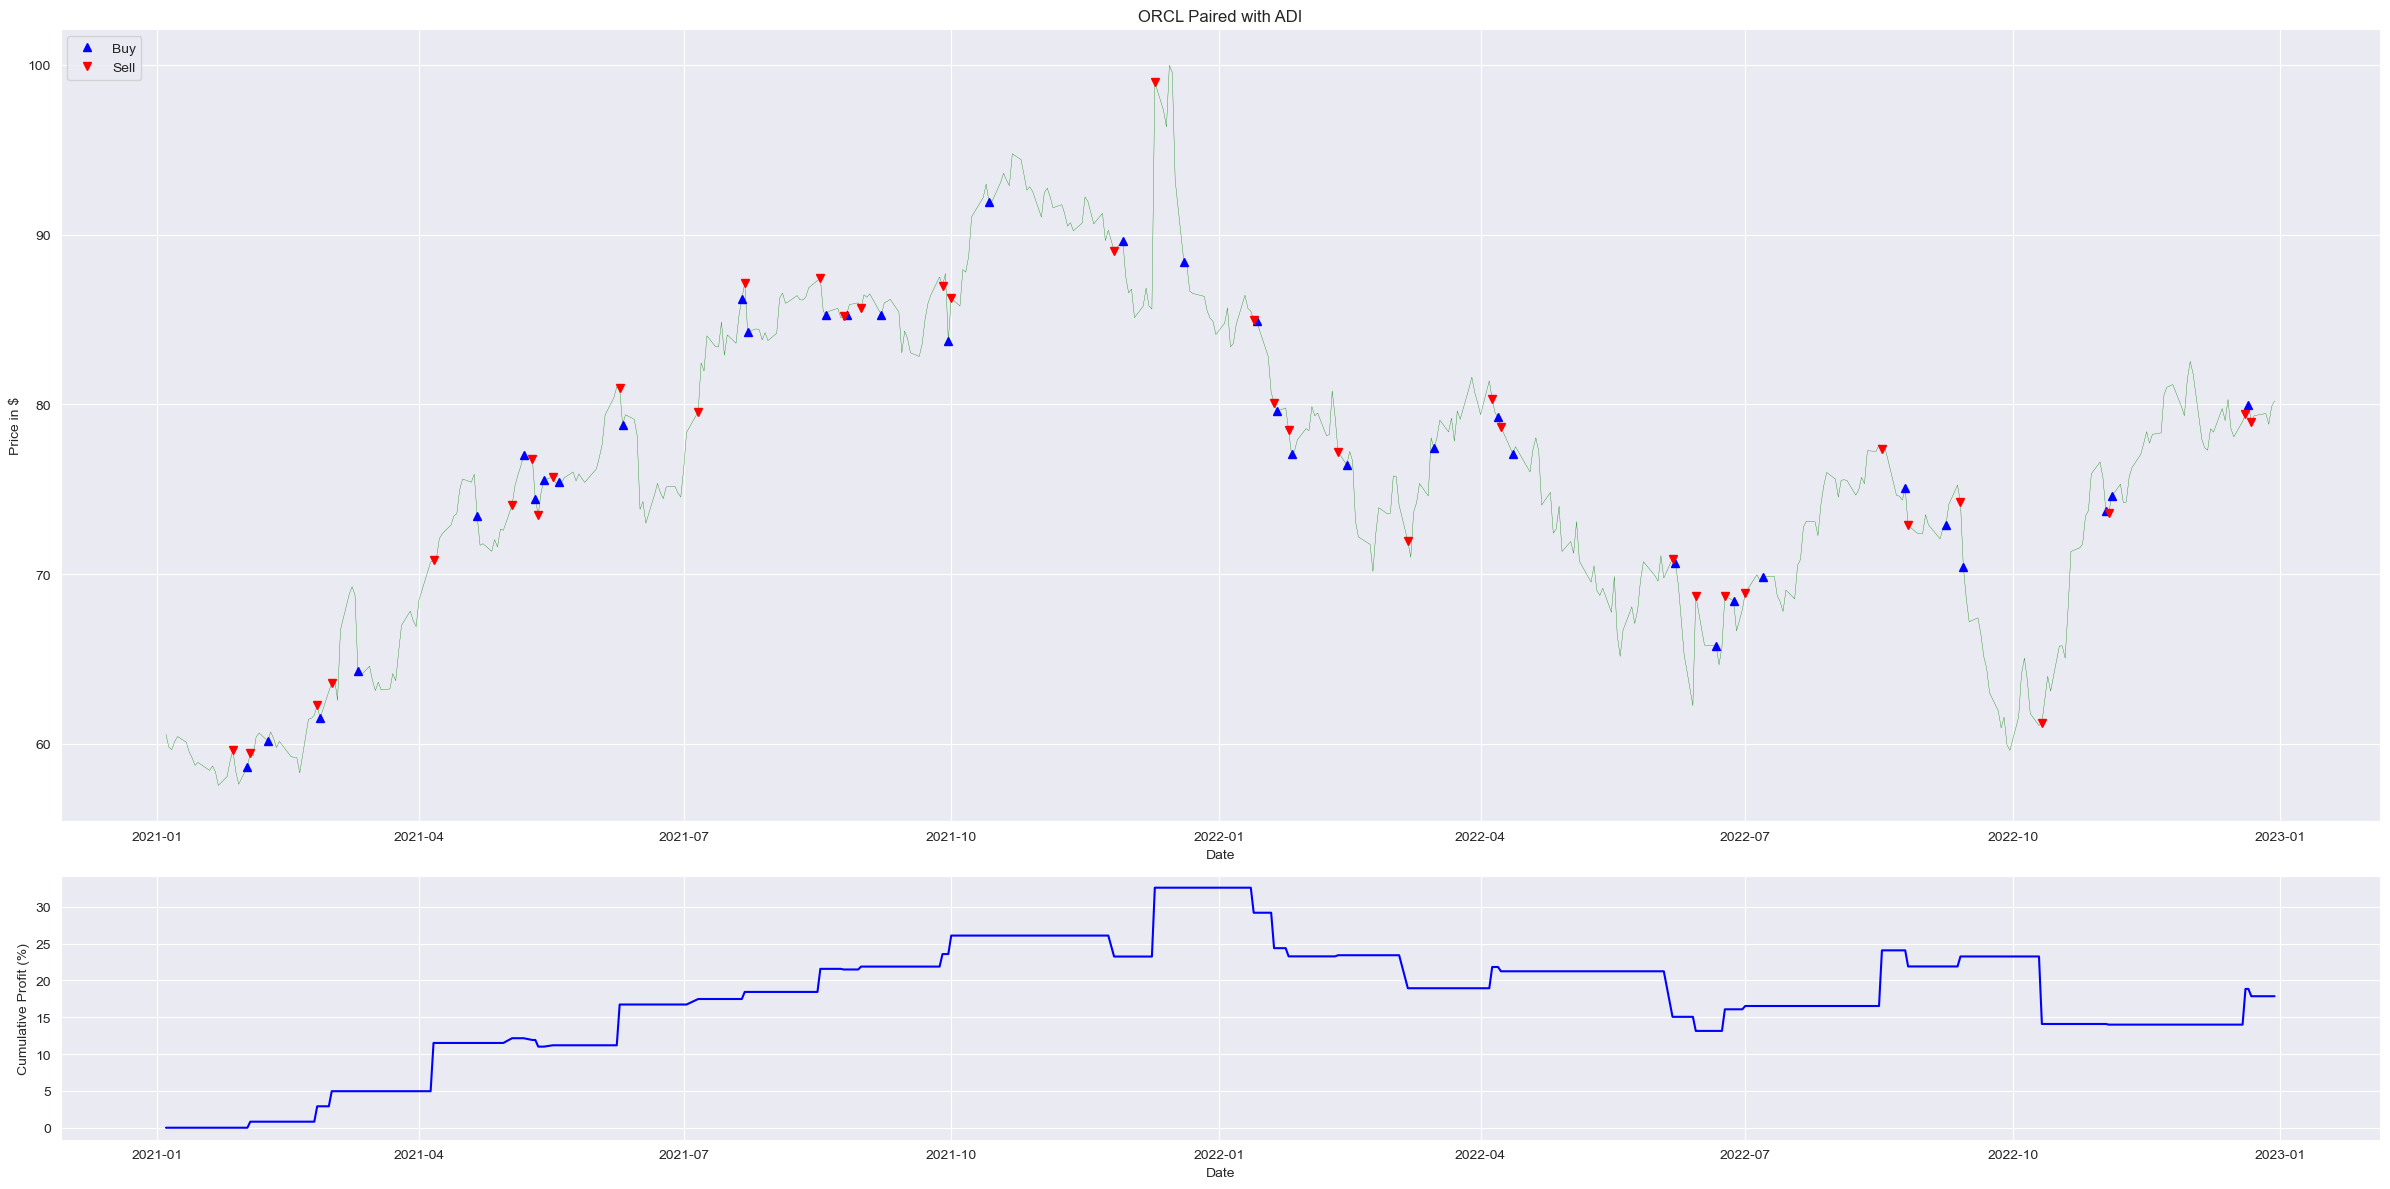

In [15]:
# Plot the results
plt.figure(figsize=(26, 18))
profit_ADI = calculate_profit(signals_ADI, data['ADI'])
ax1, _ = plot_strategy(data['ADI'], signals_ADI, profit_ADI)

profit_ORCL = calculate_profit(signals_ORCL, data['ORCL'])
ax2, _ = plot_strategy(data['ORCL'], signals_ORCL, profit_ORCL)

ax1.legend(loc='upper left')
ax1.set_title('ADI Paired with ORCL')
ax2.legend(loc='upper left')
ax2.set_title('ORCL Paired with ADI')
plt.tight_layout()
plt.show()

In a portfolio, the two strategies would be uses together, thus it makes sense to represent the cumulative return of the overall strategy as the sum of the two of them.

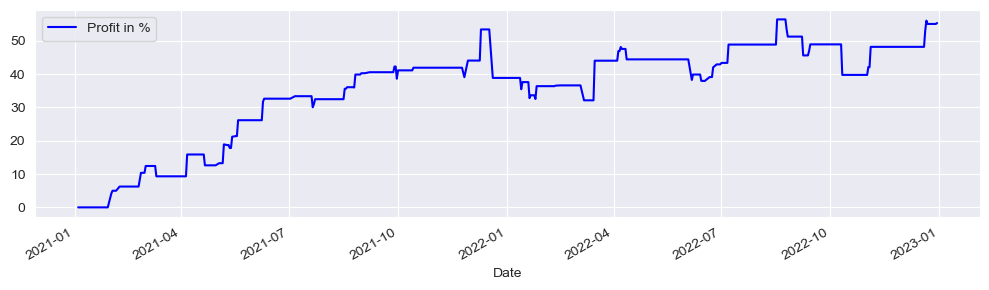

In [16]:
plt.figure(figsize=(10, 3))
cumulative_profit = profit_ADI + profit_ORCL
ax_combined = cumulative_profit.plot(label='Profit in %', color='blue')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

Let's evaluate how the strategy would have perform after '2023-01-01'. We confirmed that our two stocks were cointegrated from '2021-01-01' to '2023-01-01'. However, this information might not be true in the future. 

In [17]:
# Import the data
tickers_= ['ADI','ORCL']
data = yf.download(tickers_, start='2023-01-01', end='2024-03-01')['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [18]:
# Retrieve the signals
signals_ADI, signals_ORCL = generate_signals(data, tickers_)

<Figure size 2600x1800 with 0 Axes>

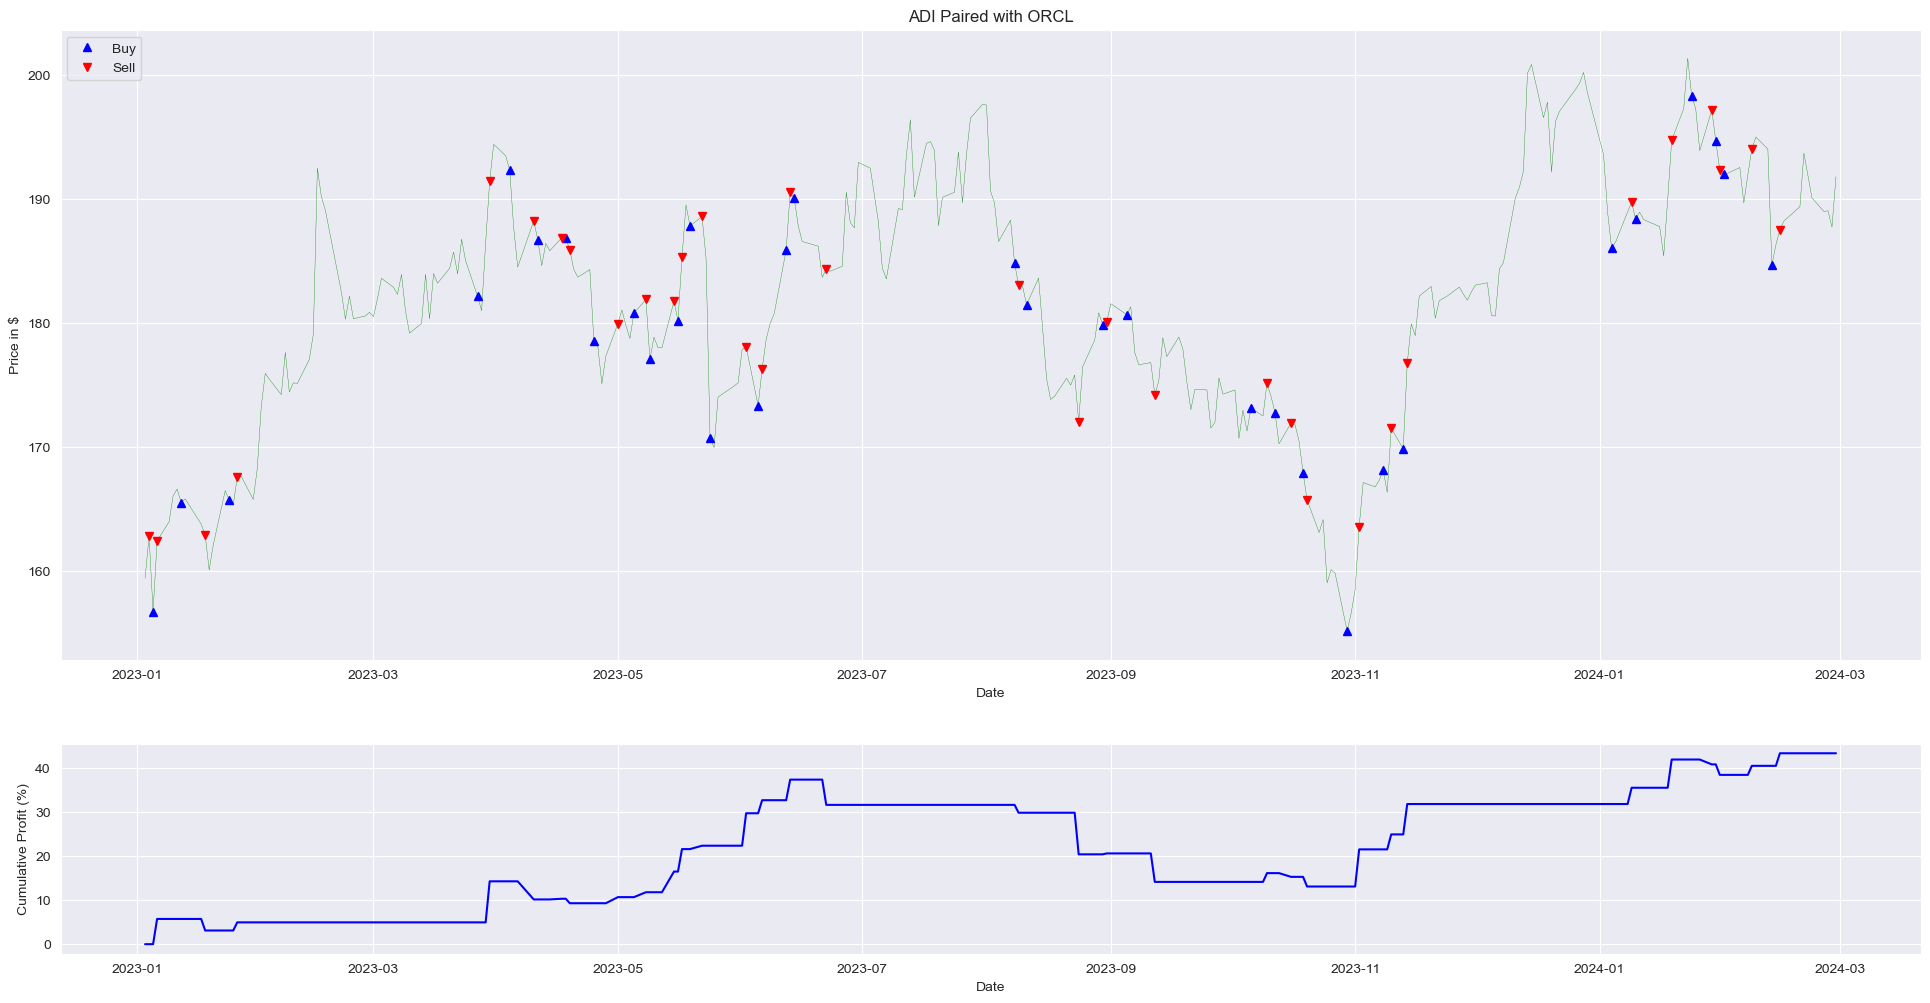

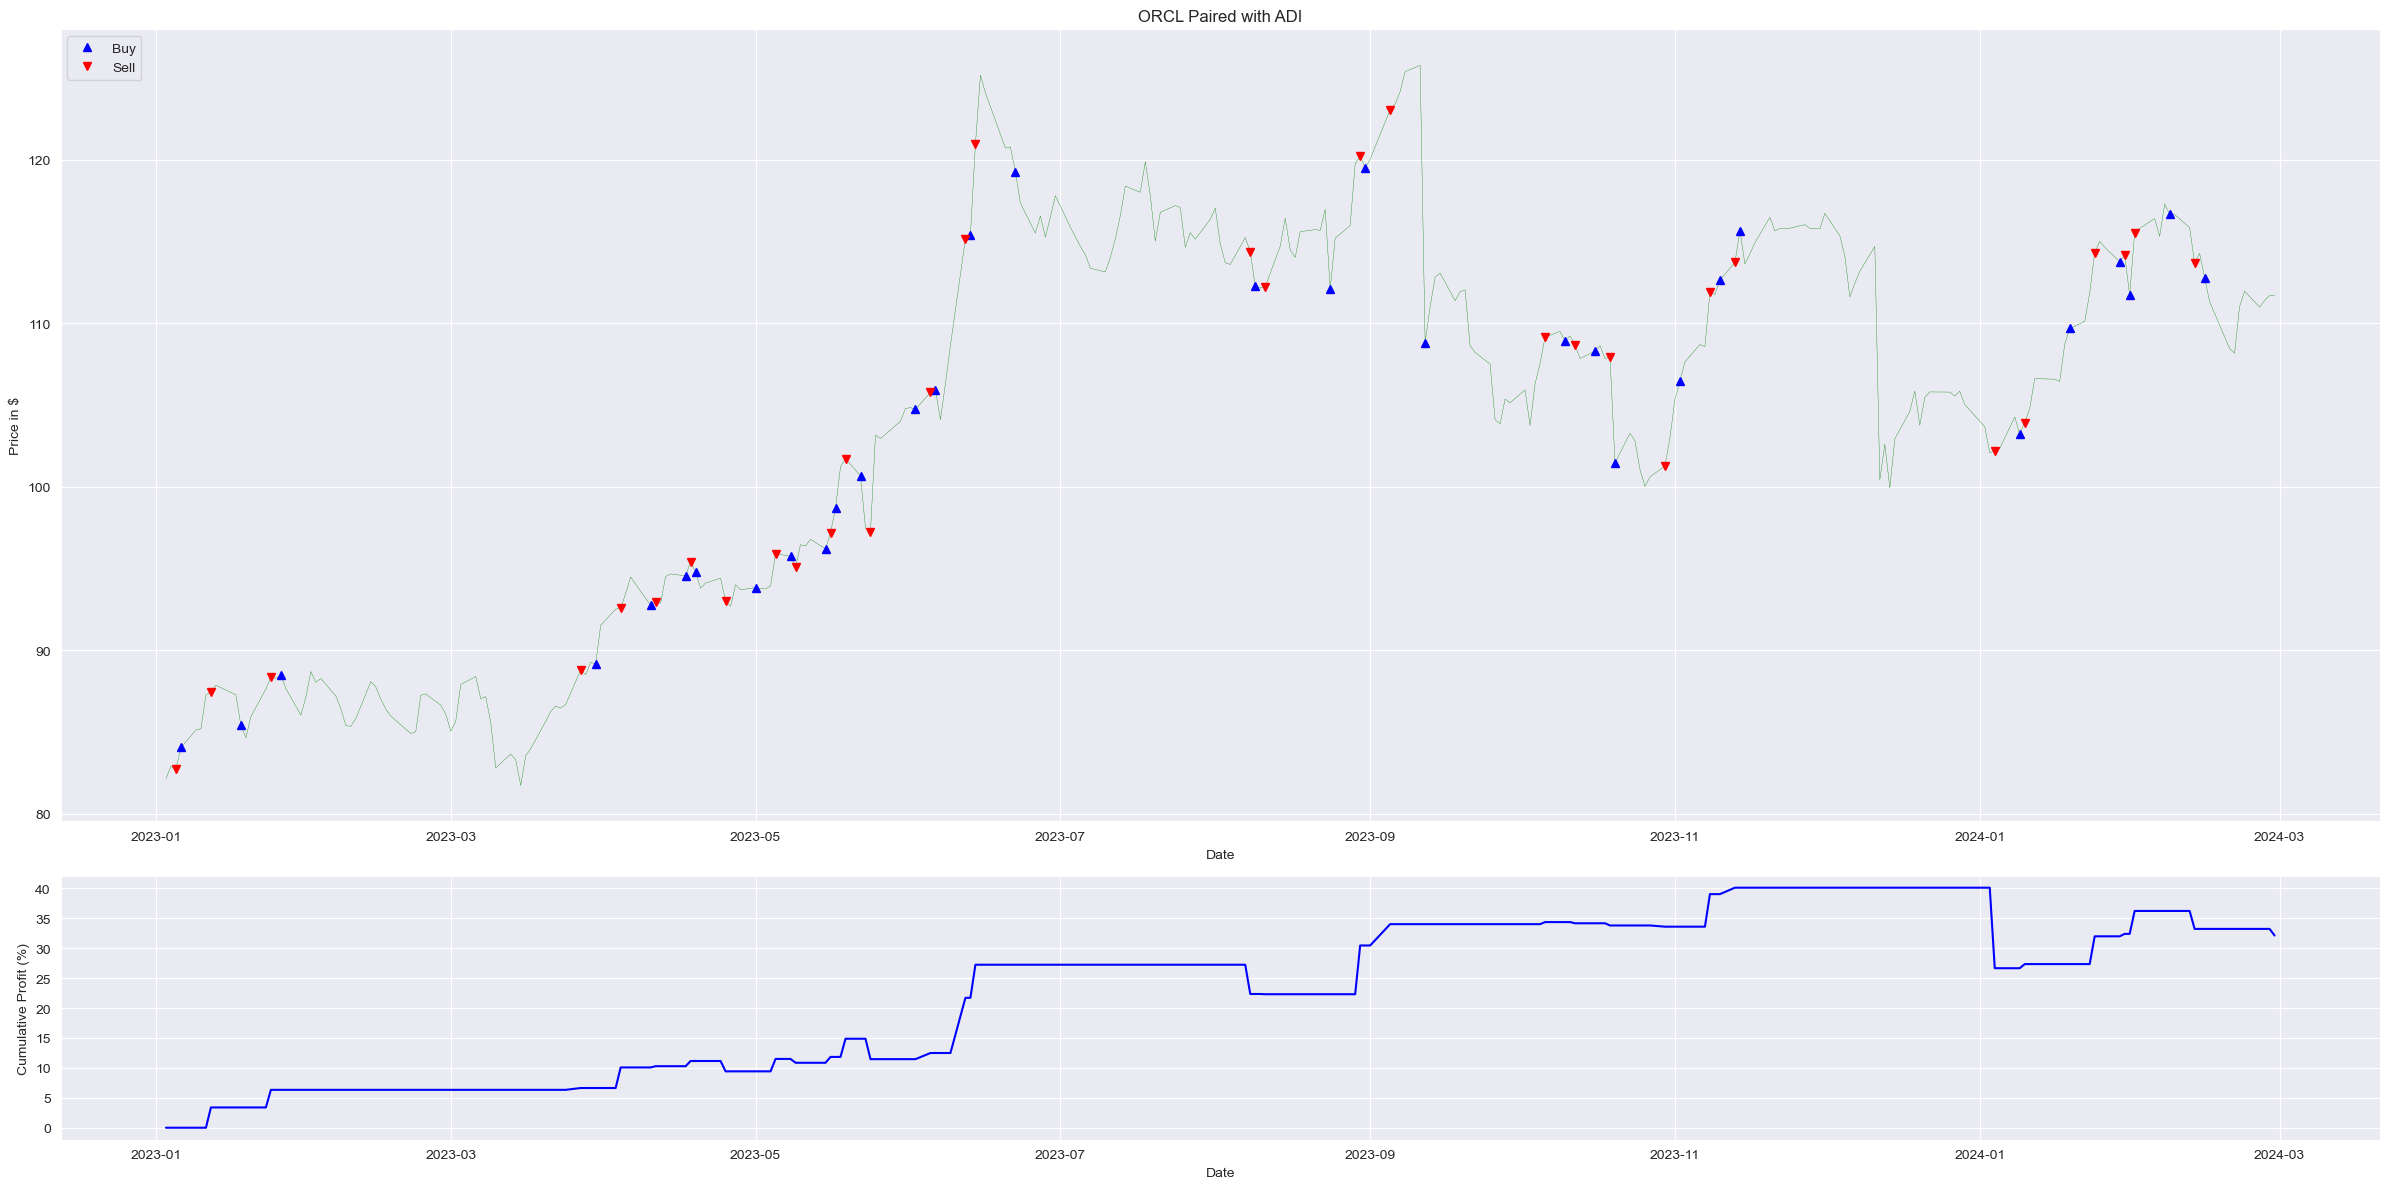

In [19]:
plt.figure(figsize=(26, 18))
profit_ADI = calculate_profit(signals_ADI, data['ADI'])
ax1, _ = plot_strategy(data['ADI'], signals_ADI, profit_ADI)

profit_ORCL = calculate_profit(signals_ORCL, data['ORCL'])
ax2, _ = plot_strategy(data['ORCL'], signals_ORCL, profit_ORCL)

ax1.legend(loc='upper left')
ax1.set_title('ADI Paired with ORCL')
ax2.legend(loc='upper left')
ax2.set_title('ORCL Paired with ADI')
plt.tight_layout()
plt.show()

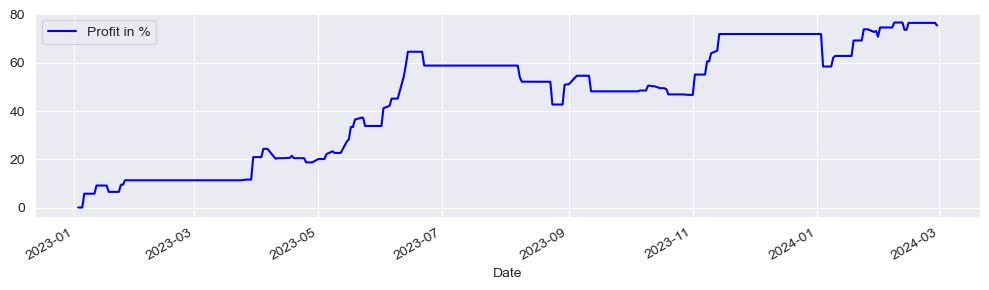

In [20]:
# Plot the cumulative return as if we started to trade our strategy beginning on '2023-01-01'
plt.figure(figsize=(10, 3))
cumulative_profit = profit_ADI + profit_ORCL
ax_combined = cumulative_profit.plot(label='Profit in %', color='blue')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

**Pair-Trading Strategy using Options**

There are several ways to get data for options trading:
- Brokerage Platforms: Many online brokerage platforms provide options data. For example, Think or Swim (TOS), a platform developed by Tasty Trade’s Tom Sossnoff and now owned by TD Ameritrade, provides options data1.
- Financial Websites: Websites like Yahoo Finance provide options data. You can use web scraping tools to extract the data, but be sure to comply with the website’s terms of service2.
- Data Providers: There are specialized data providers that offer detailed options data, often for a fee34.
- Exchange Websites: Some exchanges, like the Chicago Board Options Exchange (CBOE), provide historical options data5.
- Financial Software: Bloomberg’s terminal offers a 90-day lookback of historical options prices1.
- Data Marketplaces: Platforms like Cboe DataShop provide custom, detailed historical data5.

Several of the sources I mentioned provide options data for free, but the amount and detail of the data may vary:
- Brokerage Platforms: Some online brokerage platforms provide options data for free, but you may need to have an account with them.
- Financial Websites: Websites like Yahoo Finance provide options data for free. You can manually search for the options data on the website.
- Exchange Websites: Some exchanges provide a limited amount of free data. For example, the Chicago Board Options Exchange (CBOE) provides some free options data.